### Разведочный анализ данных(EDA), препроцессинг, бинарная классификация для датасета, состоящего из данных людей, с оценкой заработной платы: человек зарабатывает больше или меньше 50_000 (по предварительным данным, скорее всего речь идет про 50_000 $ в год)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
import plotly.express as px
import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, auc,
f1_score, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix,
classification_report, fbeta_score)
from imblearn.over_sampling import SMOTE, ADASYN

In [6]:
salary_df = pd.read_csv('data/salary_data.csv')
salary_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [7]:
len(salary_df)

48842

Изучим датасет: общую информацию и уникальные категориальные переменные по каждому признаку

In [8]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [9]:
salary_category = salary_df.select_dtypes(include='object')
for col in salary_category.columns:
    pprint.pprint(f'{col} имеет уникальные значения: {salary_category[col].unique()}')

("workclass имеет уникальные значения: ['Private' 'Local-gov' '?' "
 "'Self-emp-not-inc' 'Federal-gov' 'State-gov'\n"
 " 'Self-emp-inc' 'Without-pay' 'Never-worked']")
("education имеет уникальные значения: ['11th' 'HS-grad' 'Assoc-acdm' "
 "'Some-college' '10th' 'Prof-school'\n"
 " '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'\n"
 " '12th' '1st-4th' 'Preschool']")
("marital-status имеет уникальные значения: ['Never-married' "
 "'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'\n"
 " 'Married-spouse-absent' 'Married-AF-spouse']")
("occupation имеет уникальные значения: ['Machine-op-inspct' 'Farming-fishing' "
 "'Protective-serv' '?'\n"
 " 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'\n"
 " 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'\n"
 " 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']")
("relationship имеет уникальные значения: ['Own-child' 'Husband' "
 "'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']")
("race и

В признаке native-country много уникальных значений. Проверим по количеству каждого, чтобы выявить маржинальные и минориальные категории

In [10]:
salary_category['native-country'].value_counts()

native-country
United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru         

#### Вывод:
- При фича инжиниринге выделить United-States(USA), остальное в NoUSA

В датасете присутствуют знаки "?", которые говорят об отсутствии инфоормации. Посчитаем количество

In [11]:
count_rows_with_mark = (salary_df == '?').sum()
count_rows_with_mark

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Их количество не так велико, можно воспользоваться изменением "?" на категорию Unknown
Изучим также числовые переменные в датафрейме

In [12]:
salary_num = salary_df.select_dtypes(include='int64')
salary_num

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,25,226802,7,0,0,40
1,38,89814,9,0,0,50
2,28,336951,12,0,0,40
3,44,160323,10,7688,0,40
4,18,103497,10,0,0,30
...,...,...,...,...,...,...
48837,27,257302,12,0,0,38
48838,40,154374,9,0,0,40
48839,58,151910,9,0,0,40
48840,22,201490,9,0,0,20


In [13]:
count_more_50 = salary_df[salary_df['income'] == ">50K"].shape[0]
print("Количество людей с зарплатой выше 50К:", count_more_50, ", что составляет", (round(count_more_50 / len(salary_df), 2)) * 100, "%")

Количество людей с зарплатой выше 50К: 11687 , что составляет 24.0 %


Набор данных несколько несбалансирован, поскольку более 3/4 записей принадлежат к сегменту заработной платы >50k. Сегмент зарплаты <=50k составляет всего 24%

Построим гистограммы распределения(количества) по каждому из числовых признаков

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'educational-num'}>,
        <Axes: title={'center': 'capital-gain'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>]], dtype=object)

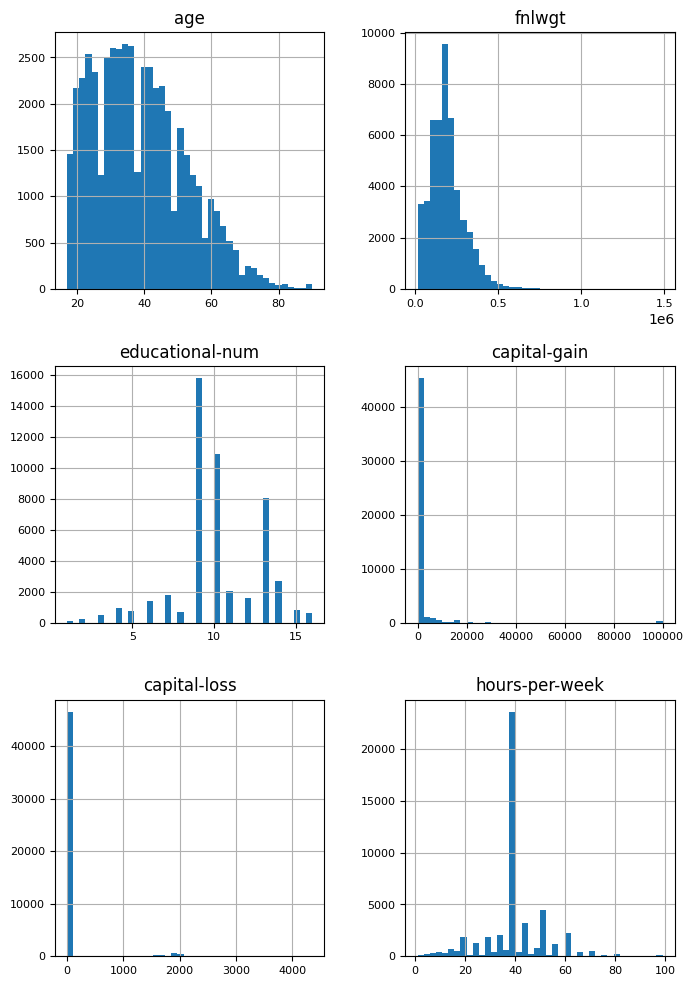

In [14]:
salary_num.hist(figsize=(8, 12), bins=40, xlabelsize=8, ylabelsize=8)

Построим графики распределения по каждому из категориальных признаков

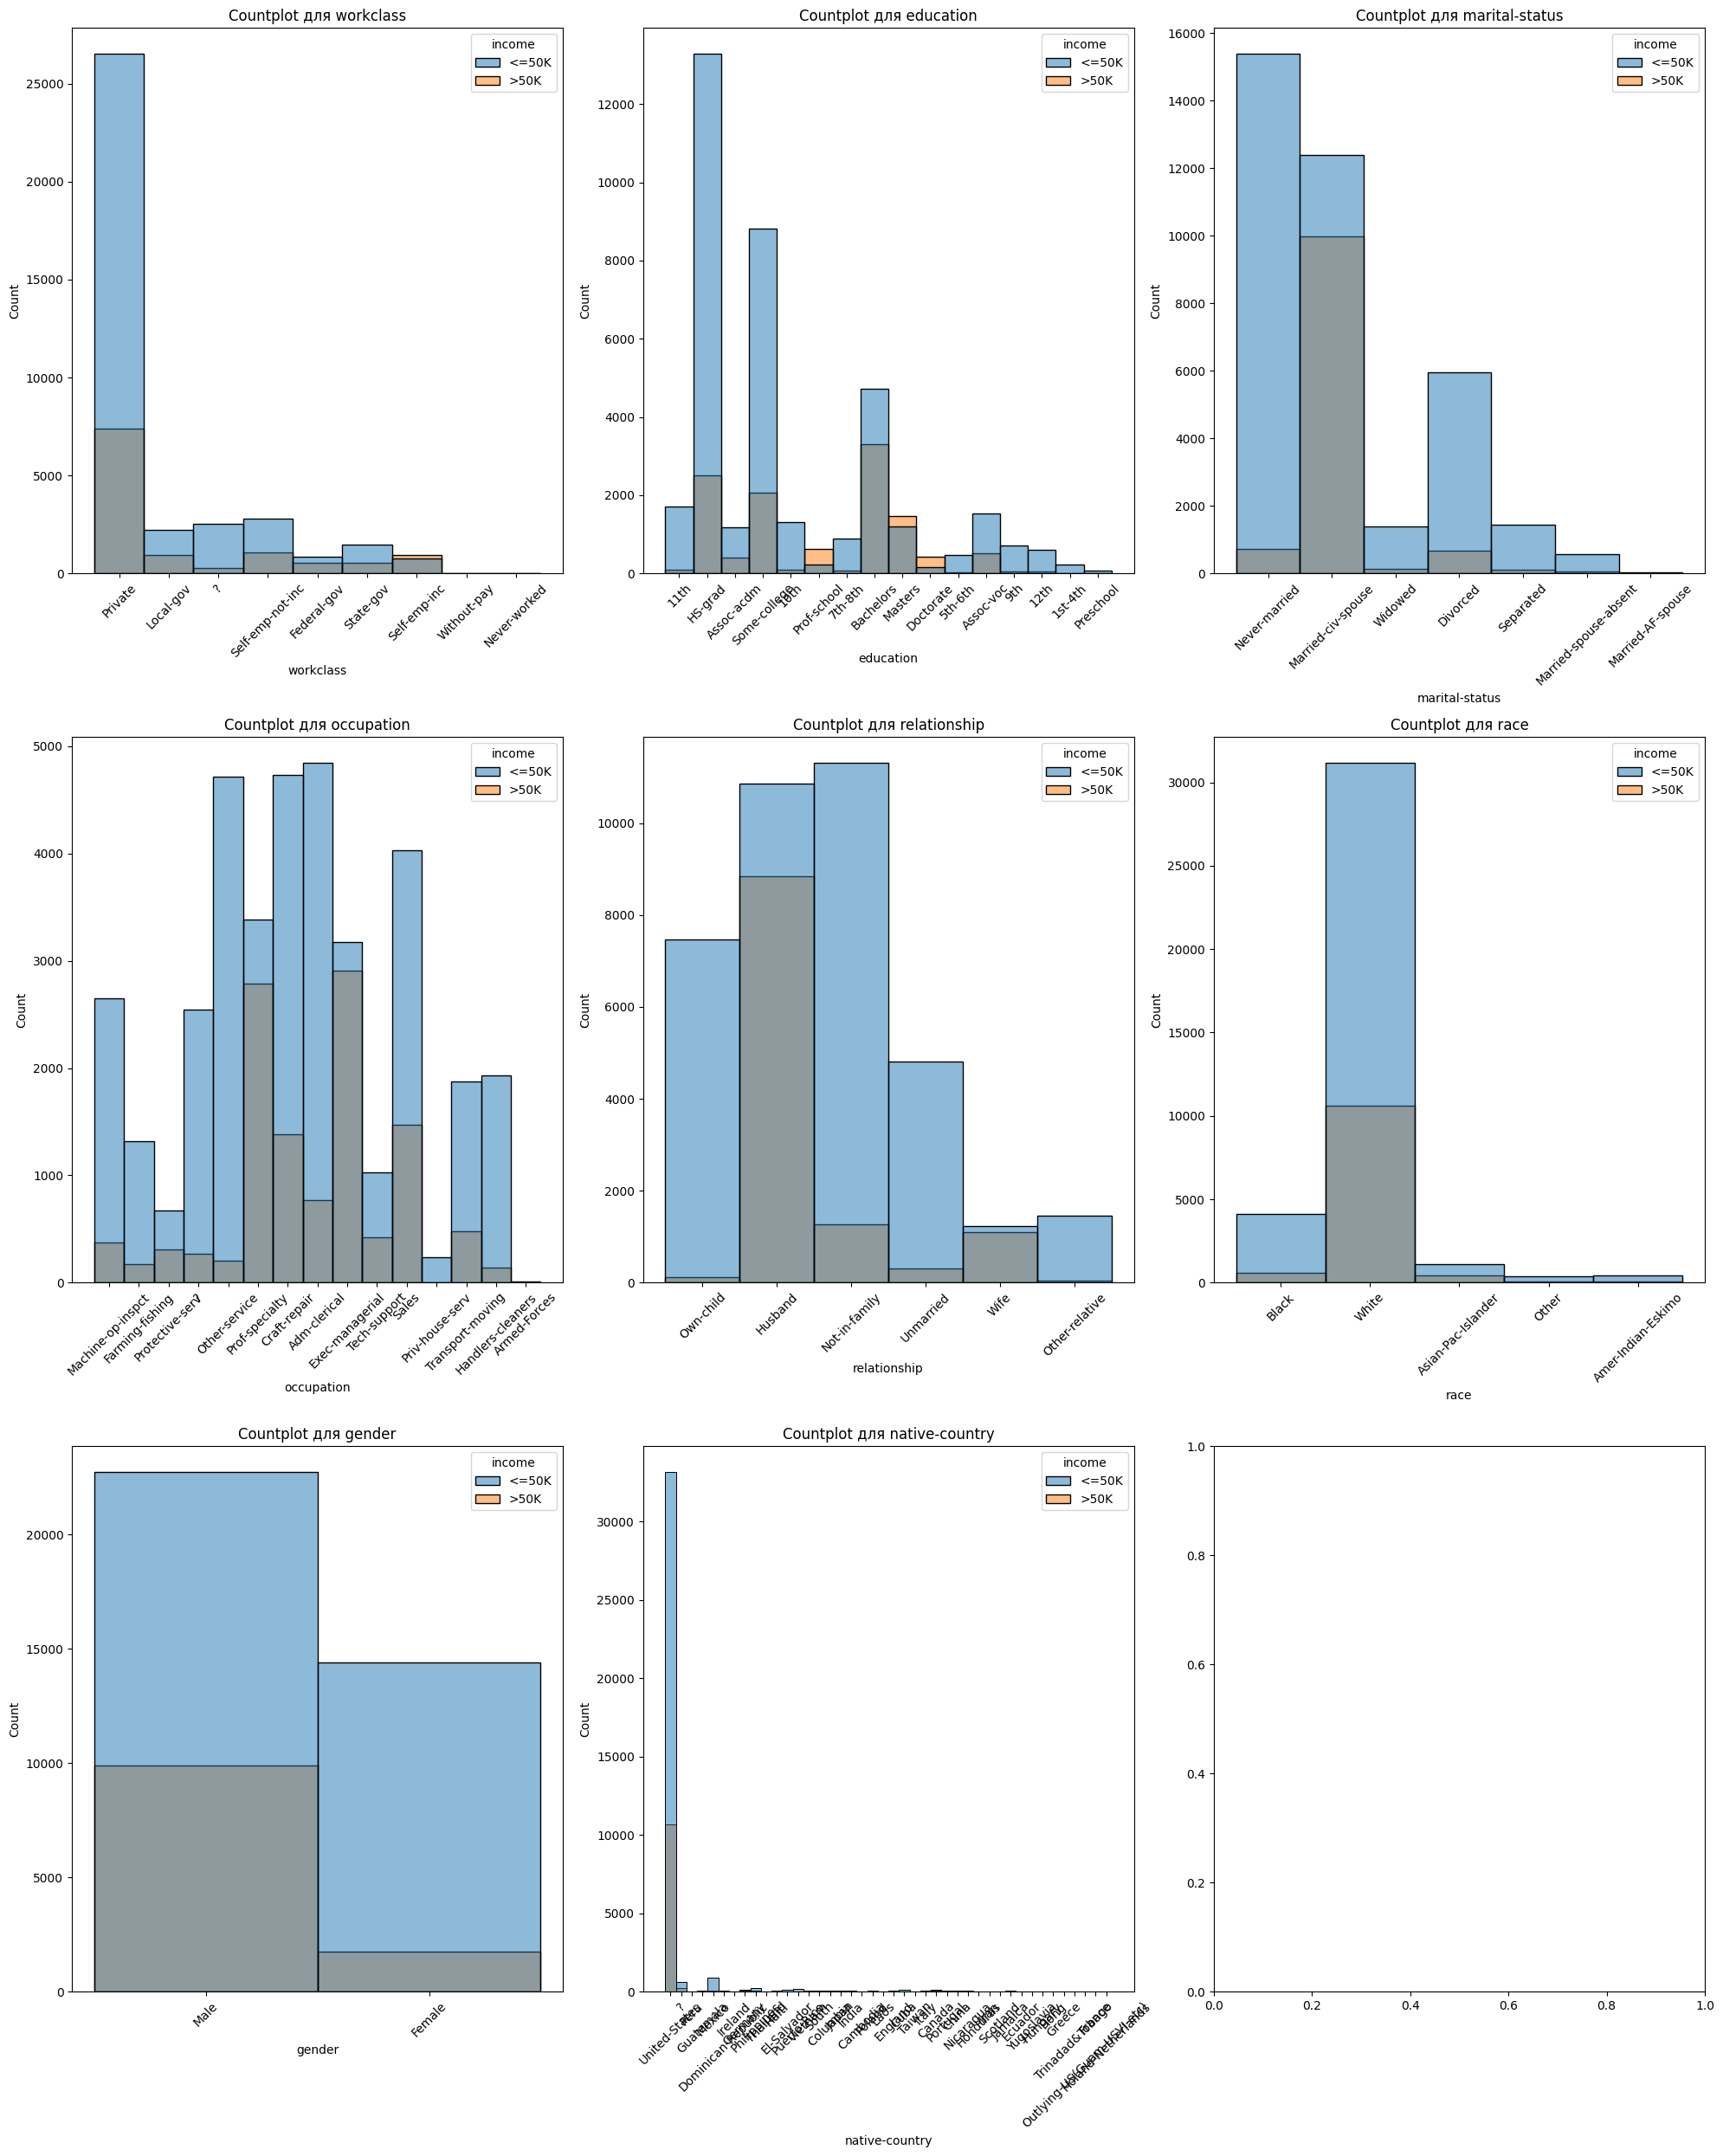

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(20,25))

axes = axes.flatten()

for i, column in enumerate(salary_category):
    if column == 'income':
        continue
    sns.histplot(data=salary_category, x=column, hue='income', bins=40, ax=axes[i])
    axes[i].set_title(f'Countplot для {column}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Вывод:
- Большинство людей, которые зарабатываают более 50К имеют высшее образование (бакалавр)
- Женатые люди имеют более высокую зарплату, также как и люди белой расовой принадлежности
- Почти все жены зарабатывают от 50К в год, но большинство людей имеют статус мужа

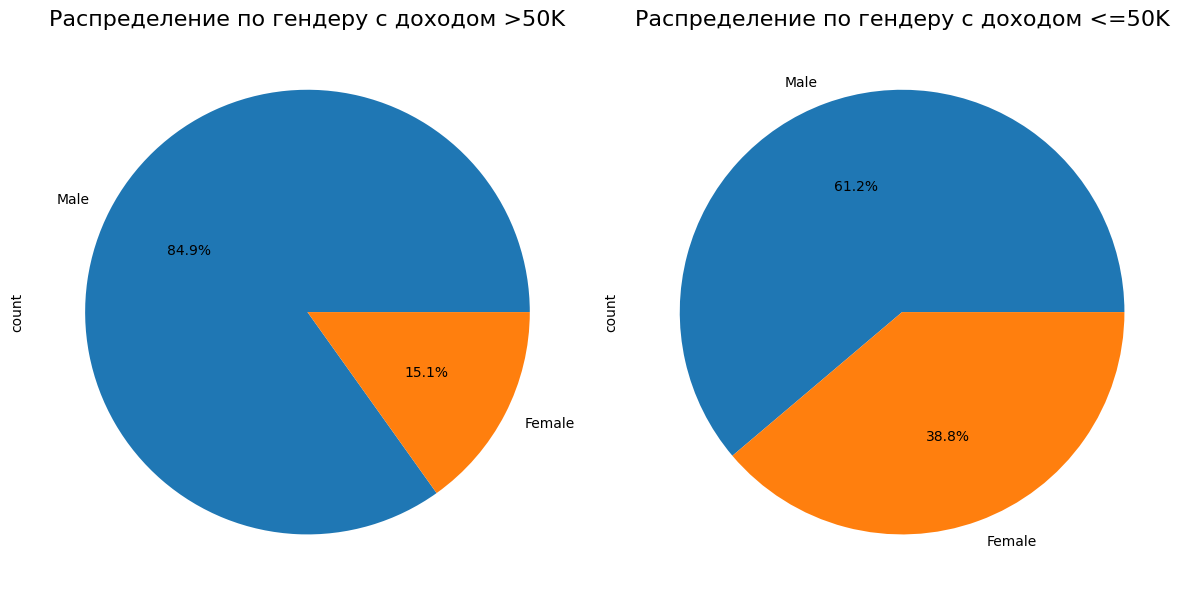

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12,10))
axes = axes.flatten()

axes[0].set_title('Распределение по гендеру с доходом >50K', fontsize=16)
salary_df[salary_df['income']=='>50K']['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[0])

axes[1].set_title('Распределение по гендеру с доходом <=50K', fontsize=16)
salary_df[salary_df['income']=='<=50K']['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[1])

plt.tight_layout()
plt.show()

Можем наблюдать неравное соотношение вне зависимости от дохода преобладают мужчины.

Построим более осмысленные графики распределения по каждому из признаков

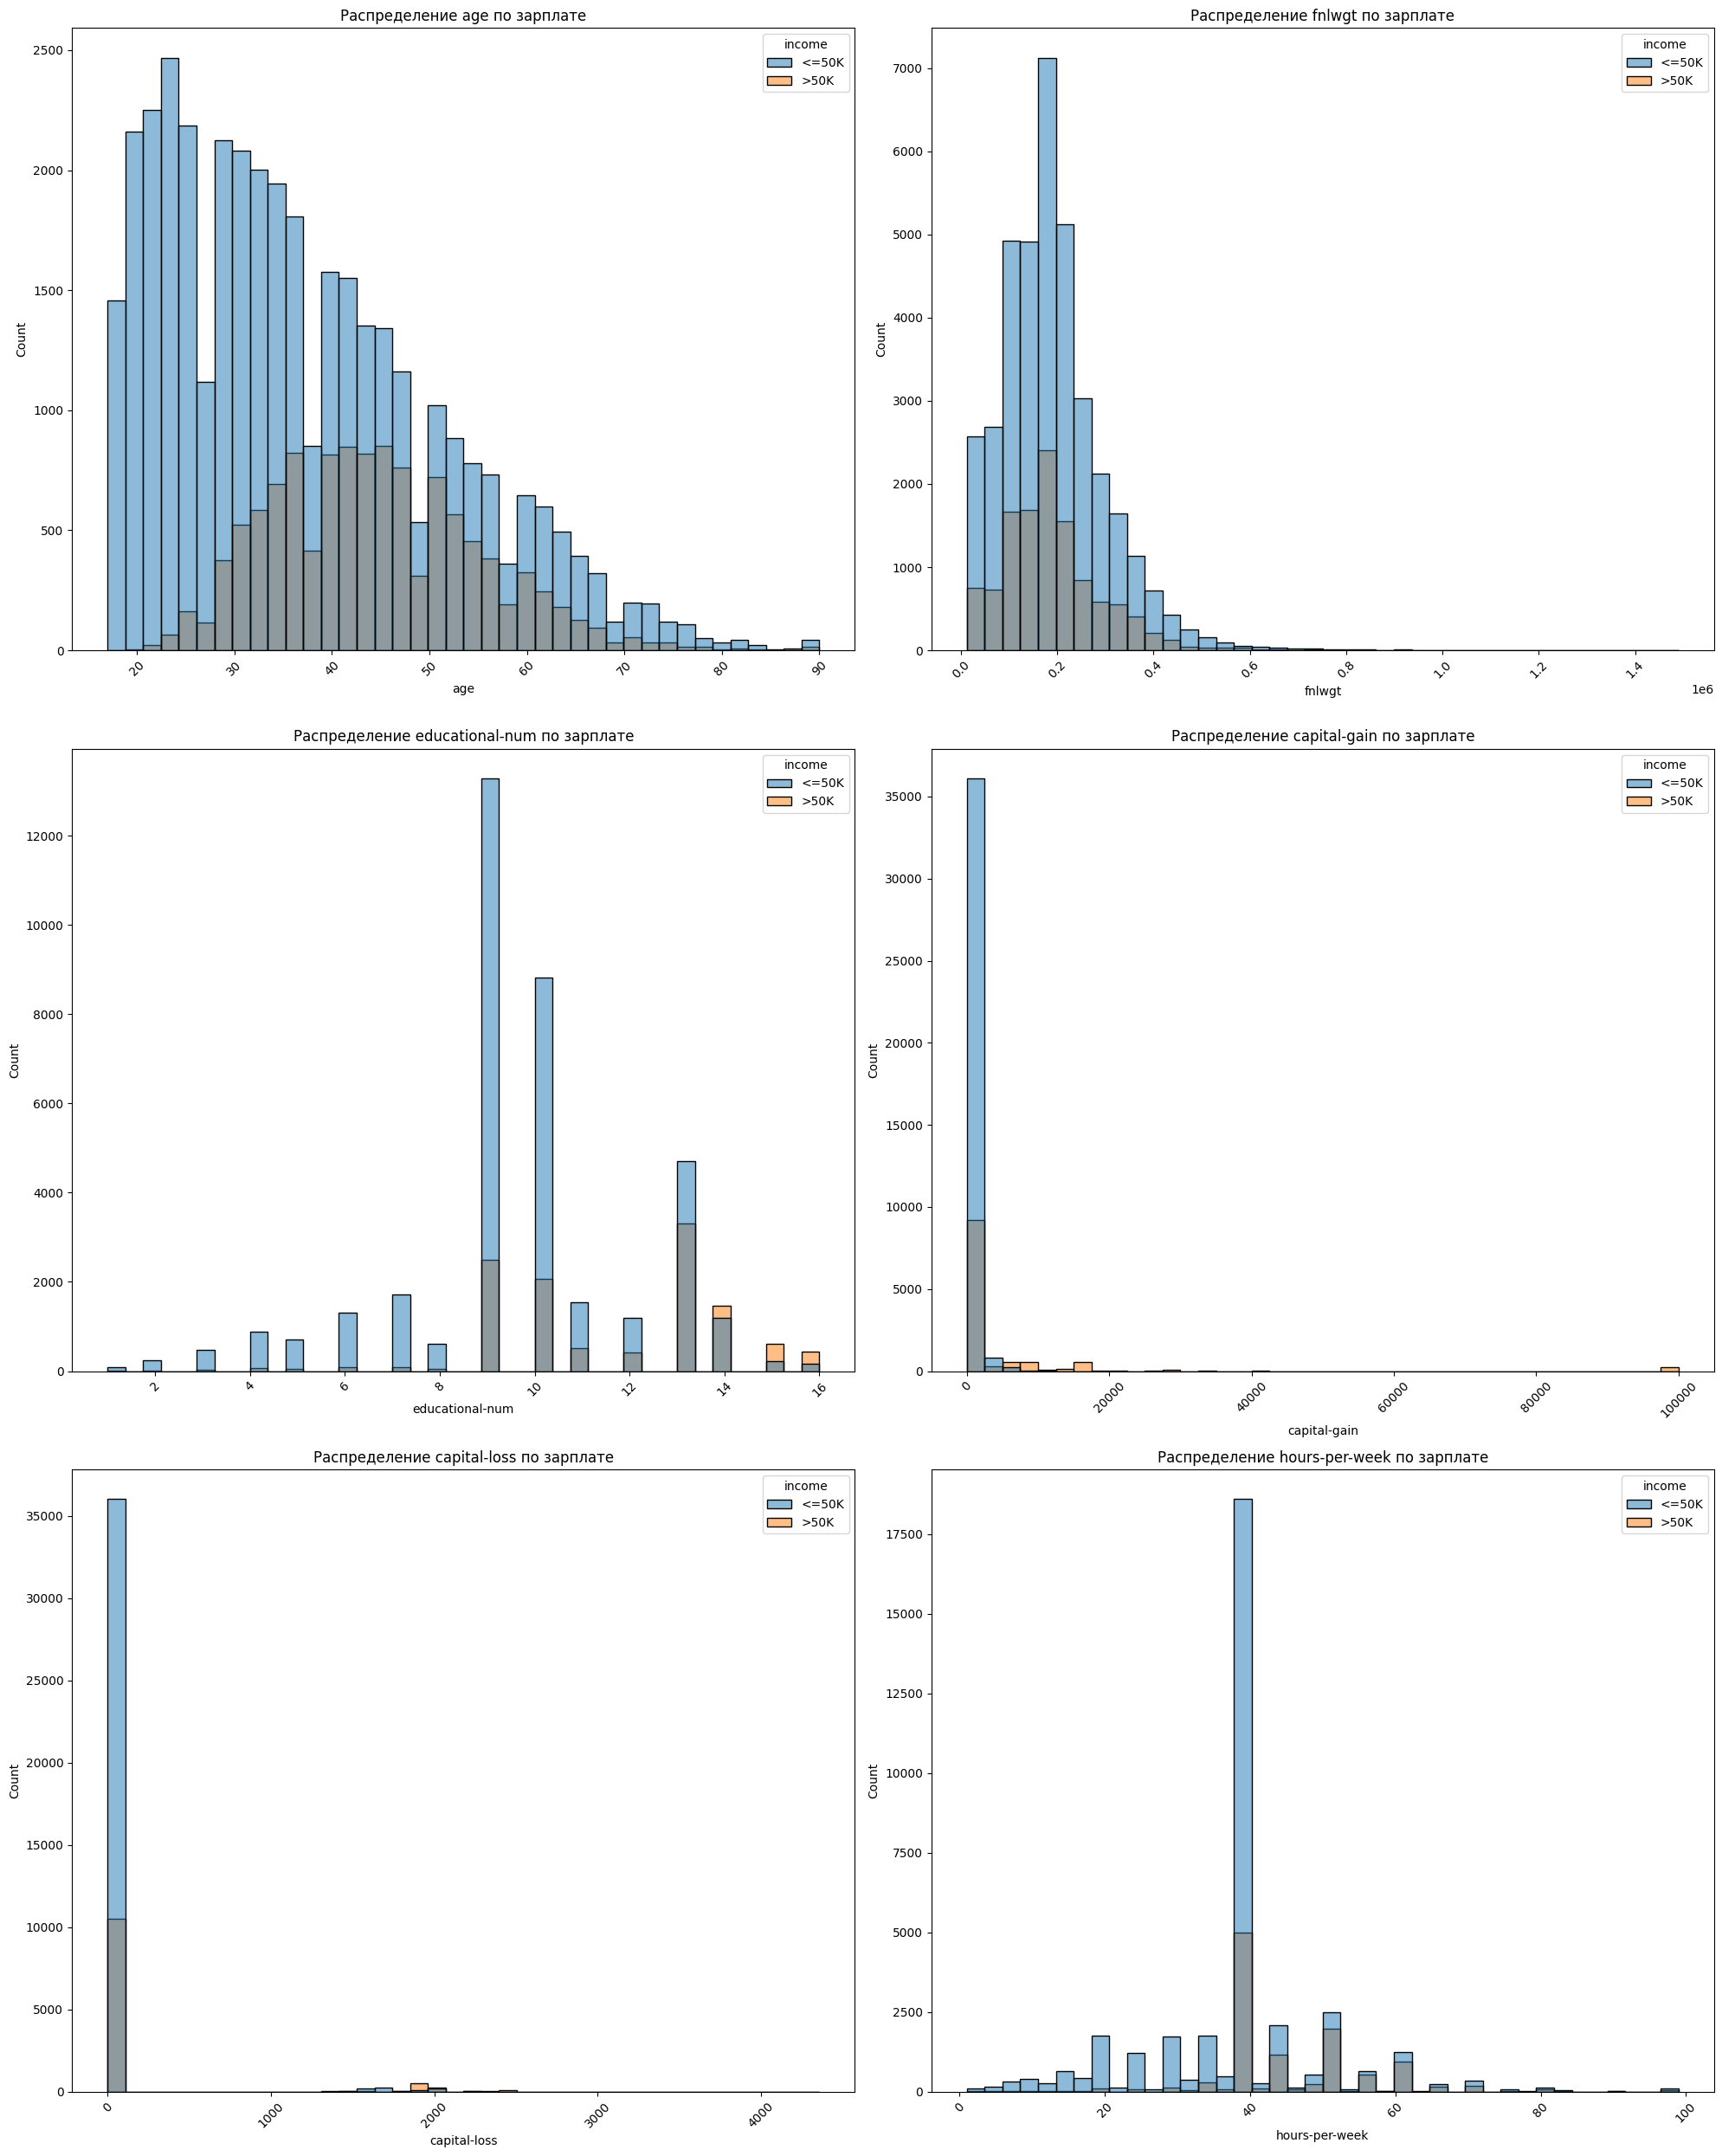

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20,25))

axes = axes.flatten()

for i, column in enumerate(salary_num):
    sns.histplot(data=salary_df, x=column, hue='income', bins=40, ax=axes[i])
    axes[i].set_title(f'Распределение {column} по зарплате')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Вывод:

- По возрастному признаку: люди, с зарплатой выше 50К преимущественно имеют возраст от 30 до 52
- Убыток капитала несут люди с зарплатой выше 50К
- С увеличением образовательного числа(возможно речь про количество лет обучения), также растет и зарплата: чем больше это количество, тем больше финансовая составляющая
- Прирост капитала также наблюдается у людей, чья зарплата выше 50К. У остальных же наблюдается стагнация
- Большинство людей работает по 40 часов в неделю. К тому же люди, зарабатывающие выше среднего, работают от 40 часов, о чем свидетельствует график распределения hours-per-week

In [18]:
round(salary_num.describe(), 2)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.00,48842.00,48842.00,48842.00,48842.0,48842.00
mean,38.64,189664.13,10.08,1079.07,87.5,40.42
std,13.71,105604.03,2.57,7452.02,403.0,12.39
min,17.00,12285.00,1.00,0.00,0.0,1.00
25%,28.00,117550.50,9.00,0.00,0.0,40.00
50%,37.00,178144.50,10.00,0.00,0.0,40.00
75%,48.00,237642.00,12.00,0.00,0.0,45.00
max,90.00,1490400.00,16.00,99999.00,4356.0,99.00


Построим тепловую матрицу(матрицу ассоциаций), чтобы понять как и какие признаки связаны между собой. Чем светлее ячейка, тем выше зависимость

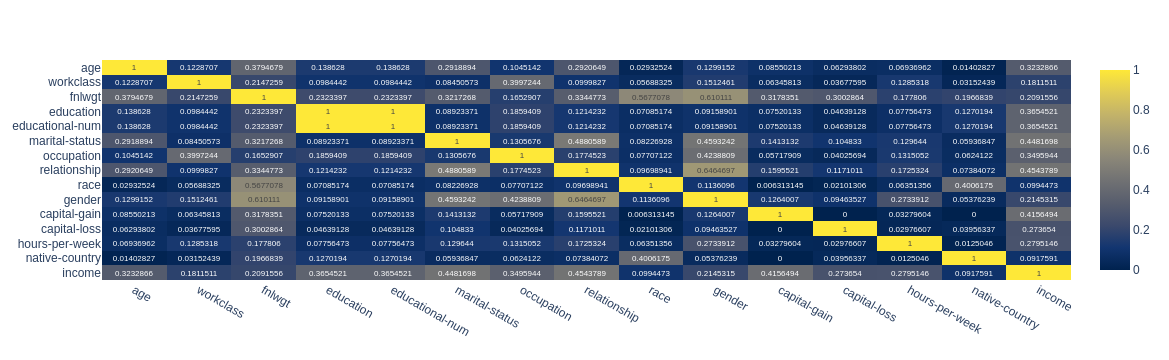

In [19]:
associations_df = associations(salary_df, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
fig = px.imshow(corr_matrix ,text_auto=True, aspect="auto" , color_continuous_scale = "cividis")
fig.show()

#### Вывод:
- Учебное заведение и количество лет обучения имеют прямую зависимость
- Видна связь между признаками relationship и income. Возможно, семейное положение влияет на уровень дохода
- Прослеживается зависимость гендерной принадлежности и социального статуса (муж-мужчина, жена-женщина)


Построим график зависимости возраста человека от количества рабочих часов в неделю (scatter plot)

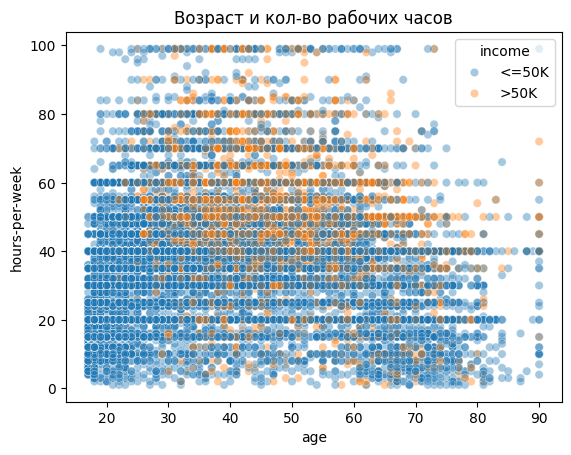

In [20]:
sns.scatterplot(data=salary_df, x='age', y='hours-per-week',
                hue='income', alpha=0.4)
plt.title('Возраст и кол-во рабочих часов')

plt.show()

## Препроцессинг данных

1. Заменим значение "?" на Unknown

In [21]:
df = salary_df.replace('?', "Unknown")

count_rows_with_mark = (df == '?').any(axis=1).sum()
count_rows_with_mark

np.int64(0)

2. Поработаем с выбросами

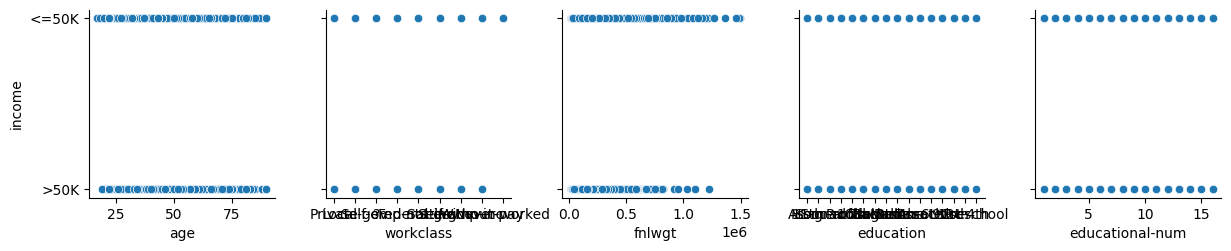

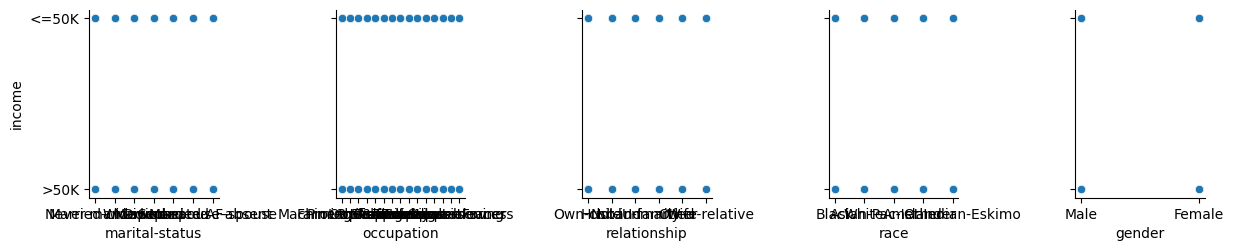

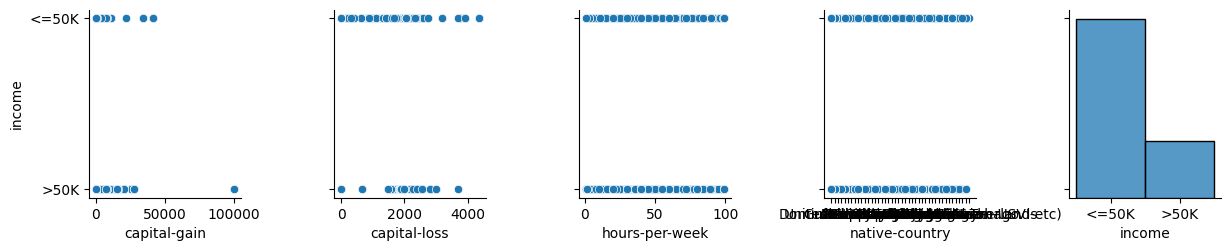

In [22]:
for i in range(0, len(salary_df.columns), 5):
    sns.pairplot(data=salary_df,
                x_vars=salary_df.columns[i:i+5],
                y_vars=['income'])

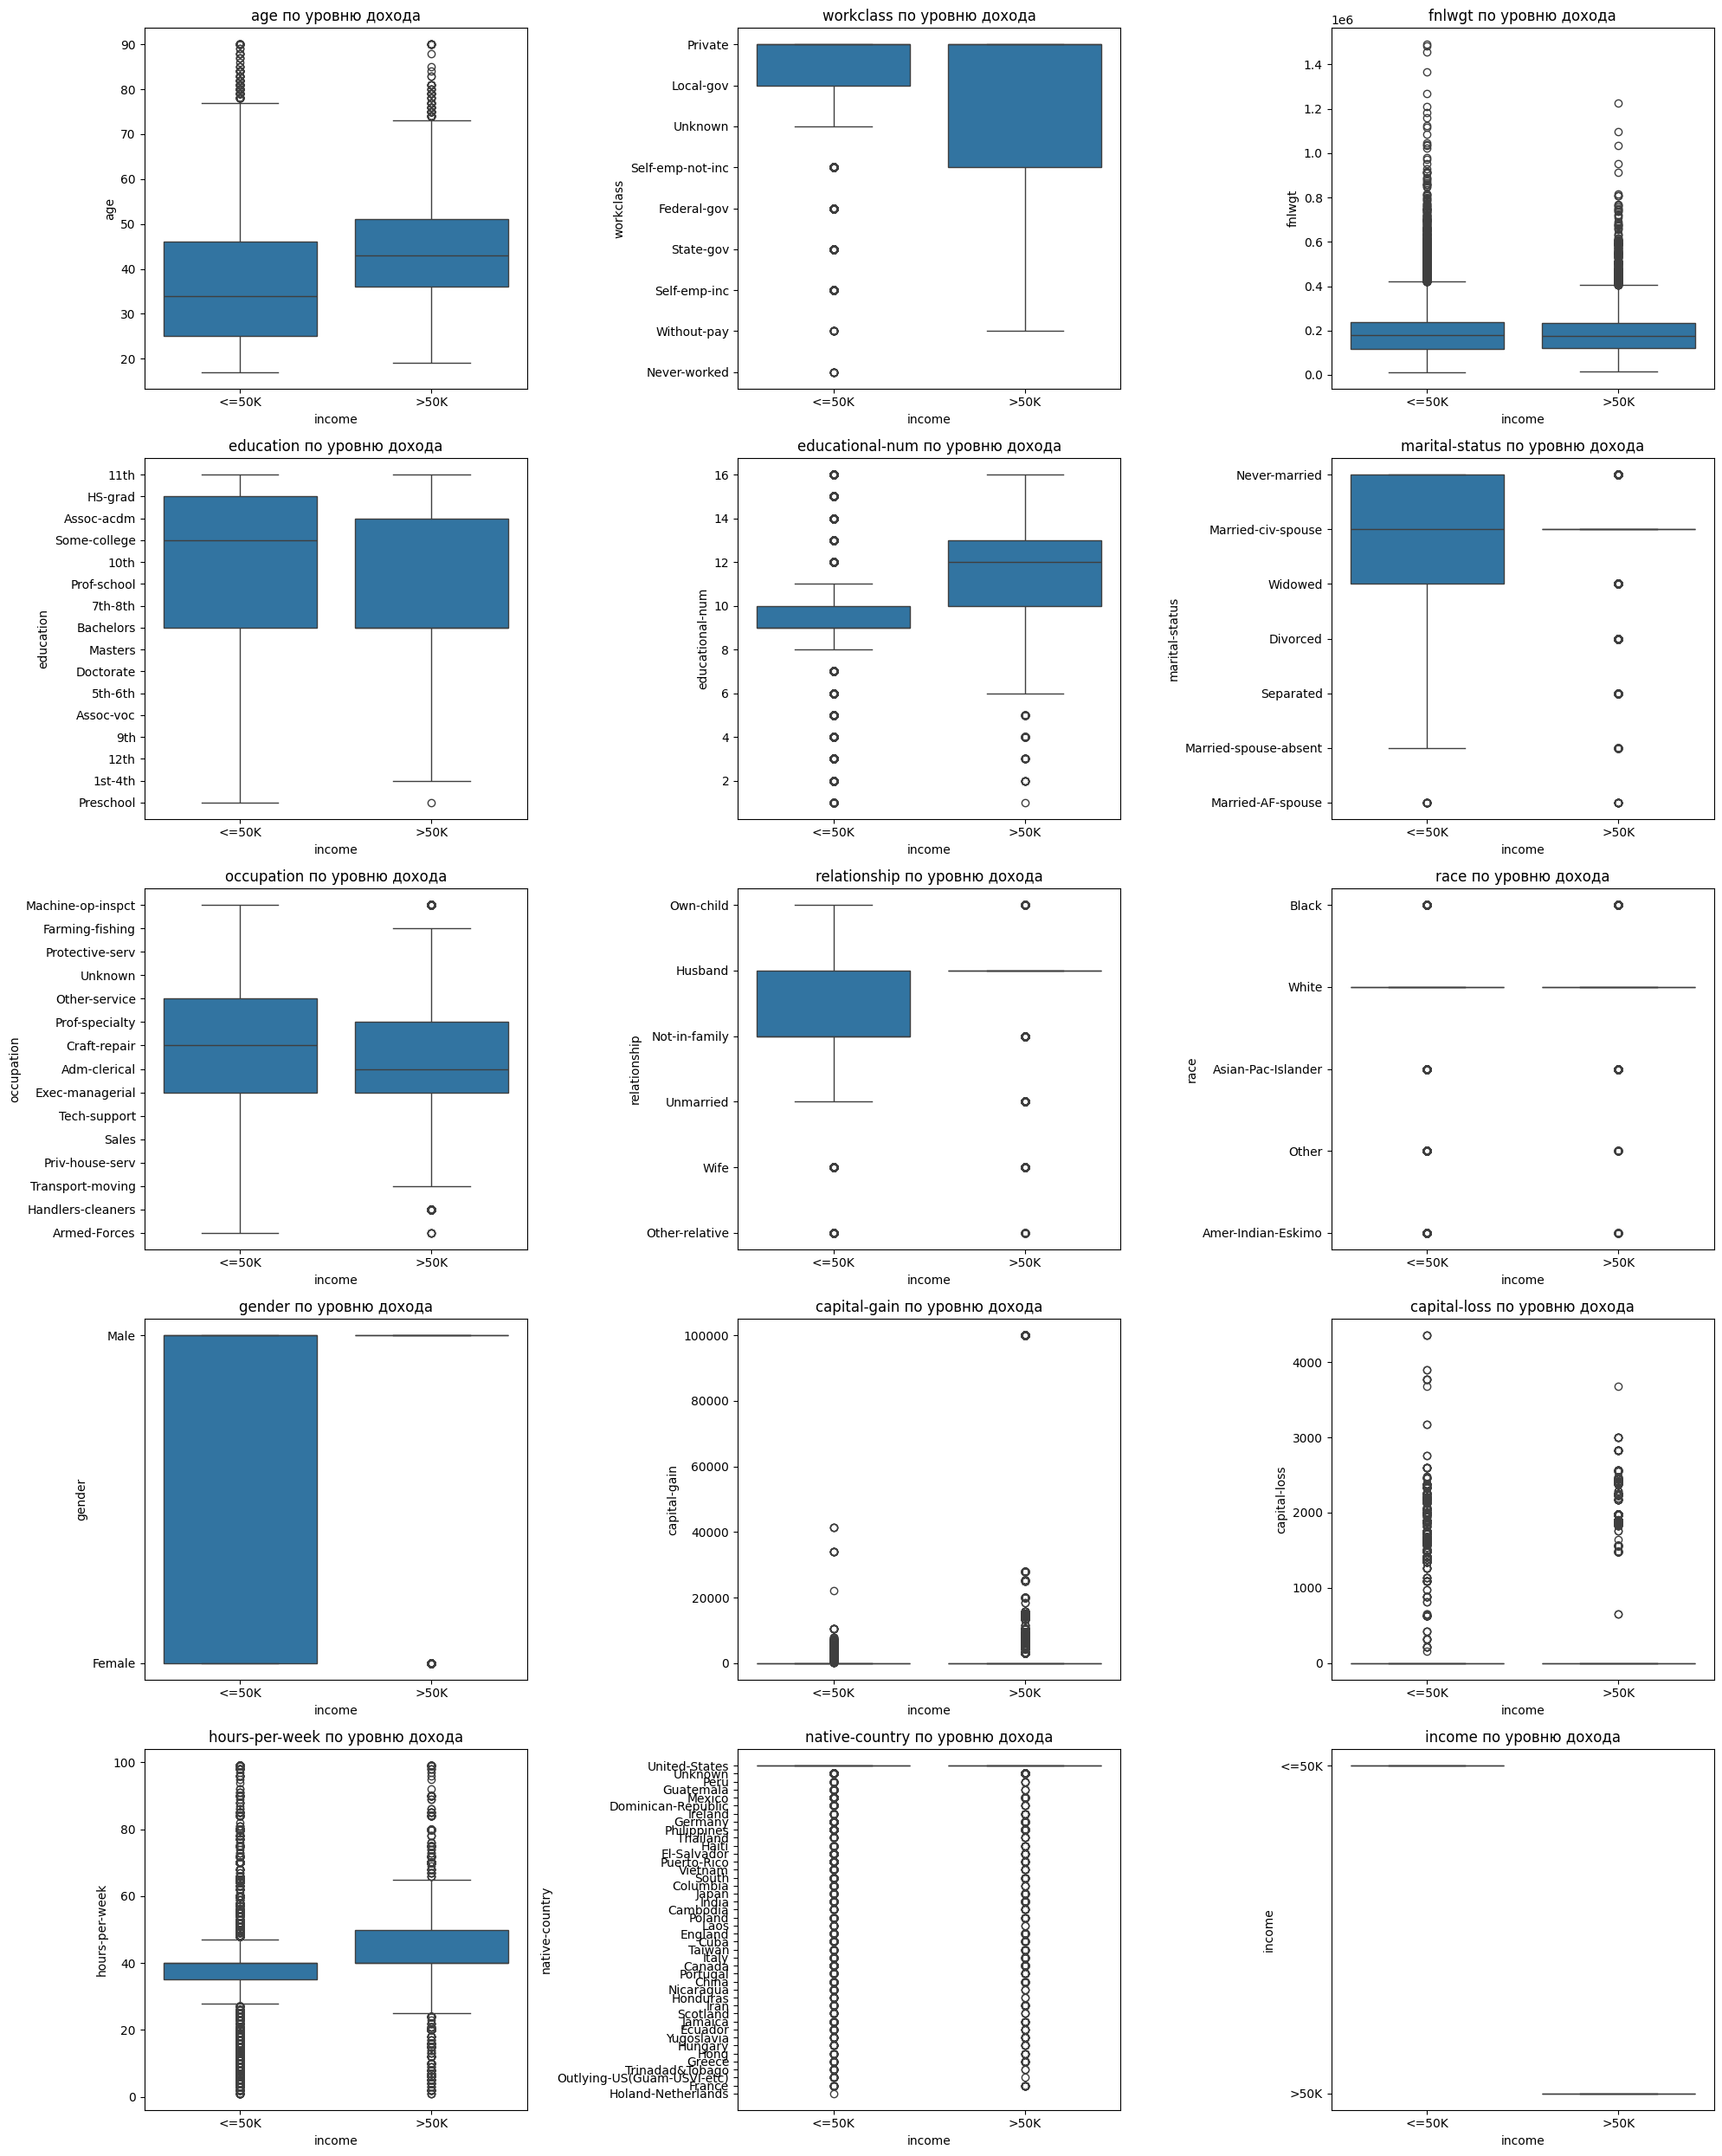

In [23]:
fig, axes = plt.subplots(5, 3, figsize=(20,25))

axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(data=df, x='income', y=col, ax=axes[i])
    axes[i].set_title(f'{col} по уровню дохода')

plt.tight_layout()
plt.show()

#### Вывод:
- Выбросы(аномалии) имеются почти в каждом признаке, особенно заметно в hours-per-week и age.

3. Нормализуем(масштабируем) и закодируем категориальные переменные (при помощи LableEncoder и OneHotEncoder). Точнее создадим функцию для нормализации и кодирования категориальных переменных + Feature Engineering и обработка выбросов
- Заменим выбросы на приближенные значения (трансформируем)
- Изменим категории native-country на 2: USA и NoUSA
- Изменим категории marital-status на 3: Never-Married, Married, Other
- В education на 3: School, Hight-edu, Other
- В race на 2: White и NoWhite
- workclass также заменим на 2 категории: Private и NoPrivate

In [102]:
def preprocess_data(df_train, df_test):
    if isinstance(df_train, pd.DataFrame):
        # Обработка выбросов по численным признакам
        numeric_cols = df_train.select_dtypes(include='int64').columns
        for col in numeric_cols:
            if col in df_test.columns:
                for df in [df_train, df_test]:
                    Q1 = df[col].quantile(0.25)
                    Q3 = df[col].quantile(0.75)
                    IQR = Q3 - Q1
                    df[col] = np.where(df[col] < Q1 - 1.5 * IQR, Q1 - 1.5 * IQR, df[col])
                    df[col] = np.where(df[col] > Q3 + 1.5 * IQR, Q3 + 1.5 * IQR, df[col])
    
        # Фича инжиниринг 
        for df in [df_train, df_test]:
            # native-country
            df['native-country'] = df['native-country'].replace({'United-States': 'USA'})
            df['native-country'] = np.where(df['native-country'] != 'USA', 'NoUSA', df['native-country'])
    
            # marital-status
            married_values = ('Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse')
            df['marital-status'] = df['marital-status'].replace({value: 'Married' for value in married_values})
            df['marital-status'] = np.where(df['marital-status'] != 'Married', 'Other', df['marital-status'])
    
            # education
            school_values = ('11th', '10th', '7th-8th', '5th-6th', '9th', '12th', '1st-4th', 'HS-grad', 'Prof-school')
            hight_edu = ('Bachelors', 'Masters', 'Doctorate')
            df['education'] = df['education'].replace({value: 'School' for value in school_values})
            df['education'] = df['education'].replace({value: 'Hight-edu' for value in hight_edu})
            df['education'] = np.where(df['education'].isin(['School', 'Hight-edu']), df['education'], 'Other')
    
            # race
            df['race'] = np.where(df['race'] != 'White', 'NoWhite', df['race'])
    
            # workclass
            df['workclass'] = np.where(df['workclass'] != 'Private', 'NoPrivate', df['workclass'])
    
        # Кодирование категориальных переменных
        binary_encoders = {}
        binary_dfs_train = []
        binary_dfs_test = []
        nominal_cat = []
    
        for col in df_train.select_dtypes(include='object').columns:
            if col in df_test.columns:
                if len(df_train[col].unique()) == 2:
                    l_encoder = LabelEncoder()
                    l_encoder.fit(df_train[col])
                    binary_encoders[col] = l_encoder
                    binary_dfs_train.append(
                        pd.DataFrame(l_encoder.transform(df_train[col]), columns=[col])
                    )
                    binary_dfs_test.append(
                        pd.DataFrame(l_encoder.transform(df_test[col]), columns=[col])
                    )
                else:
                    nominal_cat.append(col)
    
        # Объединение бинарных признаков
        train_binary_df = pd.concat(binary_dfs_train, axis=1).reset_index(drop=True) if binary_dfs_train else pd.DataFrame()
        test_binary_df = pd.concat(binary_dfs_test, axis=1).reset_index(drop=True) if binary_dfs_test else pd.DataFrame()
    
        # Кодирование номинальных категориальных переменных
        o_encoder = OneHotEncoder(drop='first', sparse_output=False)
        o_encoder.fit(df_train[nominal_cat])
    
        train_encoded_data = o_encoder.transform(df_train[nominal_cat])
        train_encoded_df = pd.DataFrame(train_encoded_data, columns=o_encoder.get_feature_names_out(nominal_cat)).reset_index(drop=True)
    
        test_encoded_data = o_encoder.transform(df_test[nominal_cat])
        test_encoded_df = pd.DataFrame(test_encoded_data, columns=o_encoder.get_feature_names_out(nominal_cat)).reset_index(drop=True)
    
        # Нормализация числовых признаков
        scaler = MinMaxScaler()
        numeric_df_train = df_train.select_dtypes(exclude='object')
        numeric_df_test = df_test.select_dtypes(exclude='object')
    
        numeric_cols = list(numeric_df_train.columns)
        scaler.fit(numeric_df_train)
    
        train_norm_numeric_df = scaler.transform(numeric_df_train)
        norm_numeric_df_train = pd.DataFrame(train_norm_numeric_df, columns=numeric_cols).reset_index(drop=True)
    
        test_norm_numeric_df = scaler.transform(numeric_df_test)
        norm_numeric_df_test = pd.DataFrame(test_norm_numeric_df, columns=numeric_cols).reset_index(drop=True)
    
        # Объединение всех признаков
        train_result = pd.concat([norm_numeric_df_train, train_binary_df, train_encoded_df], axis=1)
        test_result = pd.concat([norm_numeric_df_test, test_binary_df, test_encoded_df], axis=1)
    else:
        l_encoder = LabelEncoder()
        l_encoder.fit(df_train)
        
        train_result = l_encoder.transform(df_train)
        test_result = l_encoder.transform(df_test)
    return train_result, test_result


Разделим датасет на признаки и целевую переменную (income)

In [103]:
X = df.drop('income', axis=1)
y = df['income']

Разделим датасет на обучающую и тестовую выборки

In [104]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [105]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape,

((36631, 14), (36631,), (12211, 14), (12211,))

Применим полученную функцию к выборкам

In [106]:
x_train, x_test = preprocess_data(df_train=x_train, df_test=x_test)
y_train, y_test = preprocess_data(df_train=y_train, df_test=y_test)

Посмотрим что получилось, выведя x_train

In [107]:
x_train

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass,marital-status,race,gender,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,0.393443,0.036754,0.565217,0.0,0.0,0.000,0,0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.360656,0.756598,0.739130,0.0,0.0,0.225,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.278689,0.612336,0.739130,0.0,0.0,0.875,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.639344,0.879287,0.826087,0.0,0.0,0.375,0,0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.885246,0.372440,0.913043,0.0,0.0,0.000,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36626,0.311475,1.000000,0.391304,0.0,0.0,0.375,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36627,0.278689,0.235140,0.478261,0.0,0.0,0.875,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36628,0.180328,0.586624,0.478261,0.0,0.0,0.375,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36629,0.475410,0.208079,0.565217,0.0,0.0,0.375,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [100]:
c = pd.concat([x_train, pd.DataFrame(y_train)], axis=1)
print(c.shape)
corr_matrix = c.corr()
corr_matrix.iloc[-1].sort_values(ascending=False)

(36631, 33)


0                               1.000000
educational-num                 0.339025
hours-per-week                  0.269808
age                             0.235354
gender                          0.214068
race                            0.079776
native-country                  0.033887
occupation_Prof-specialty       0.012222
relationship_Own-child          0.010840
education_Other                 0.008112
occupation_Other-service        0.005020
relationship_Other-relative     0.004343
occupation_Sales                0.004305
occupation_Unknown              0.003317
occupation_Transport-moving     0.001457
relationship_Unmarried          0.001386
occupation_Tech-support         0.000773
occupation_Machine-op-inspct   -0.000723
occupation_Exec-managerial     -0.000846
occupation_Protective-serv     -0.002163
occupation_Handlers-cleaners   -0.002390
fnlwgt                         -0.002622
relationship_Wife              -0.003907
relationship_Not-in-family     -0.004383
occupation_Armed

Возьмем модель логистической регрессии

In [108]:
model = LogisticRegression()
logistic = model.fit(x_train, y_train)
logistic.score(x_train, y_train)

0.8304441593186099

Данная модель показывает около 83% точности. Но эта оценка качества модели является завышенной (оптимистичной), так как она оценена именно по тем данным, на которых модель училась. Чтобы оценить именно обобщающую способность модели, то есть ее способность правильно предсказывать значение целевой переменной для тех объектов, которые она не учитывала при подстройке параметров, необходимо оценить модель на тестовой выборке.

In [48]:
logistic.score(x_test, y_test)

0.842600933584473

В тестовой выборке результат выше, чем на обучающей - 84%. Это связано с тем, что данных намного меньше.

Рассчитаем предсказанные значения отдельно для тестовой и обучающей выборки

In [49]:
y_test_pred = logistic.predict(x_test)
y_train_pred = logistic.predict(x_train)

Построим матрицу ошибок

In [50]:
confusion_matrix(y_train, y_train_pred)

array([[25595,  2206],
       [ 4005,  4825]])

In [51]:
confusion_matrix(y_test, y_test_pred)

array([[8666,  688],
       [1234, 1623]])

TN  = 8676, FN = 678

FP = 11273, TP = 1584

In [52]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      9354
           1       0.70      0.57      0.63      2857

    accuracy                           0.84     12211
   macro avg       0.79      0.75      0.76     12211
weighted avg       0.83      0.84      0.84     12211



Отчет о классификации показывает ключевые метрики для каждого класса
Для класса 0(менее 50К) правильно предсказано 87%, из всех истинных правильно предсказаны 93%, 0.90 - гармоническое среднее между precision и recall
Для класса 1(более 50К) правильно предсказано 70%, из всех истинных правильно предсказаны 55%, 0.62 - гармоническое среднее между precision и recall
Общая доля правильных предсказаний - 84%

In [53]:
metrics = pd.DataFrame({
    "Train": [
        accuracy_score(y_train, y_train_pred),
        precision_score(y_train, y_train_pred),
        recall_score(y_train, y_train_pred),
        f1_score(y_train, y_train_pred),
    ],
    "Test": [
        accuracy_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred),
        recall_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred),
    ],
}, index = ["Accuracy", "Precision", "Recall", "F1"])

metrics

,Train,Test
Accuracy,0.830444,0.842601
Precision,0.686247,0.702293
Recall,0.546433,0.568078
F1,0.608411,0.628096


#### Вывод:
- Модель хорошо предсказывает класс 0, но плохо предсказывает класс 1(выше 50К)
- Из-за того что присутствует дисбаланс классов, accuracy является обманчивой метрикой, соответственно стоит сделать выбор в пользу другой метрики
- Так как нет необходимости минимизировать ложноположительные предсказания (precision) и минимизировать ложноотрицательные (recall), данную задачу бинарной классификации удобнее всего будет решать с помощью метрики  **ROC-AUC**. Связано это с дисбалансом целевых переменных (примерно 4 к 1 соотношение классов с перевесом заработка менее 50К)

Получим вероятность принадлежности по каждому классу

In [54]:
y_pred_proba = model.predict_proba(x_test)
y_pred_proba

array([[0.98456702, 0.01543298],
       [0.97307909, 0.02692091],
       [0.85022355, 0.14977645],
       ...,
       [0.96218851, 0.03781149],
       [0.91523364, 0.08476636],
       [0.36076488, 0.63923512]], shape=(12211, 2))

*Пометка*: Порог(threshold) в бинарной классификации - значение, выше которого модель относит объект к классу 1, а ниже - к 0. Поиск оптимального порога - найти значение, при котором модель показывает наилучшее соотношение между чувствительностью (TPR) и специфичностью (1 - FPR).

Выберем вероятность принадлежности к классу 1(более 50К)

In [55]:
y_pred_proba[:,1]

array([0.01543298, 0.02692091, 0.14977645, ..., 0.03781149, 0.08476636,
       0.63923512], shape=(12211,))

Вычислим TPR и FPR для разных порогов (Данная функция возвражает три массива: значения метрики FPR (false positive rate), TPR (true positive rate) и значение порога)

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

На основании полученных данных, построим график ROC

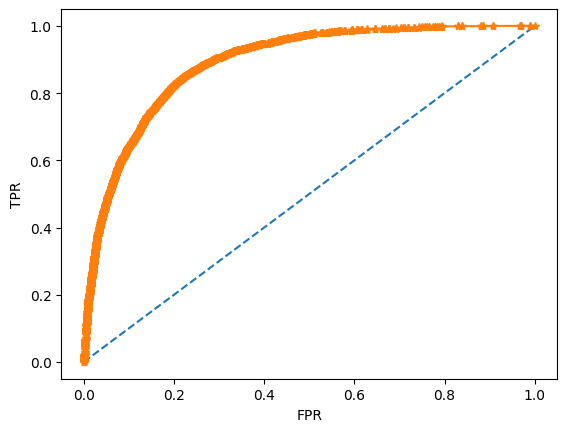

In [57]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='*')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

#### Вывод по графику:
Классификатор работает лучше, чем случайное предсказание, тк кривая находится выше референсной линии. Но график дает только примерное представление, насколько хорошо прогнозирует модель.

Чтобы найти оптимальный порог, используем среднее геометрическое между TPR и FPR как критерий оптимизации

In [58]:
geometric_mean = np.sqrt(tpr * (1 - fpr))
optimal_idx = np.argmax(geometric_mean)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_proba[:,1] >= optimal_threshold).astype(int)
y_pred

array([0, 0, 0, ..., 0, 0, 1], shape=(12211,))

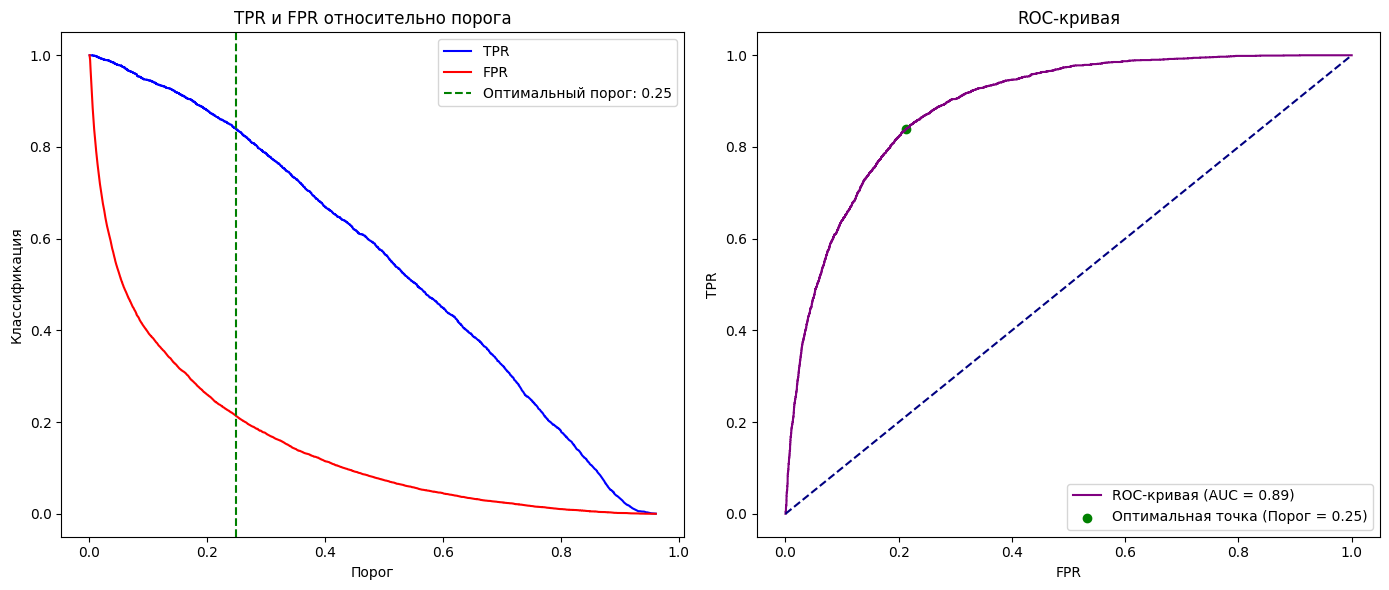

In [59]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(thresholds, tpr, label='TPR', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='red')
plt.axvline(optimal_threshold, color='green', linestyle='--', label=f'Оптимальный порог: {optimal_threshold:.2f}')
plt.xlabel('Порог')
plt.ylabel('Классификация')
plt.title('TPR и FPR относительно порога')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {auc(fpr, tpr):.2f})', color='purple')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='green', label=f'Оптимальная точка (Порог = {optimal_threshold:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend()

plt.tight_layout()
plt.show()


- Синяя линия (recall) (чувствительность) - показывает, как изменяется доля правильно классифицированных положительных объектов при изменении порога
- Красная линия - показывает, как изменяется доля ложноположительных классификаций.
- Зелёная пунктирная линия - оптимальный порог, найденный по максимуму среднего геометрического между TPR и (1 - FPR)
- ROC-кривая помогает визуально оценить качество модели

#### Вывод:
- При низких значениях порога, TPR и FPR близки к 1: модель почти все относит к классу 1 (минимизация ложноотрицательных ошибок).
- При высоких значениях порога, TPR и FPR близки к 0: модель почти все относит к классу 0 (минимизация ложноположительных ошибок).
- При оптимальном пороге, равном 0.24, достигается баланс между чувствительностью (TPR) и специфичностью (1 - FPR).

### Оптимизация порога с использованием PR-кривой и F-метрики

In [60]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

*Т.к. формула F_beta = (1 + beta^2) \* ((precision\*recall) / ((betta^2 \* precision) + recall)), то для превалирования precision надо брать beta < 1, а для recall - больше 1 (при beta=1 - оба показателя имеют равный вес(F1))*

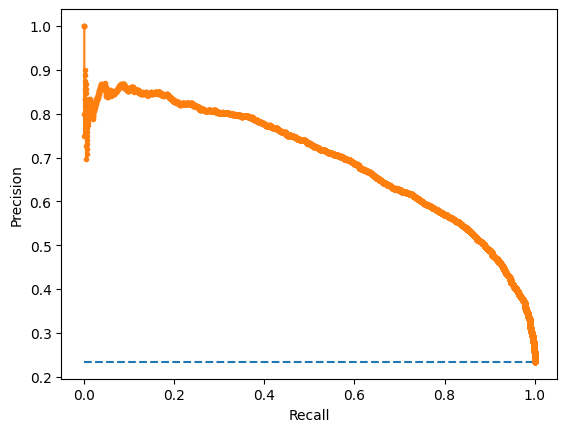

In [61]:
no_ = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_, no_], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

На графике - истинное поведение модели, более реалистические оценки эффективности работы моделей классификации на таких данных, где наблюдается большой дисбаланс классов

In [62]:
def optimal_param(beta, thresholds, y_pred_proba):
    f_scores = []
    for thr in thresholds:
        y_pred = (y_pred_proba[:, 1] >= thr).astype(int)
        f_score = fbeta_score(y_test, y_pred, beta=beta)
        f_scores.append(f_score)
    optimal_idx = np.argmax(f_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_idx, optimal_threshold

1. C преимуществом precision

In [63]:
optimal_idx_precision, optimal_threshold_precision = optimal_param(beta=0.5,
                                                                   thresholds=thresholds,
                                                                   y_pred_proba=y_pred_proba)

2. C превалированием recall

In [64]:
optimal_idx_recall, optimal_threshold_recall = optimal_param(beta=2,
                                                             thresholds=thresholds,
                                                             y_pred_proba=y_pred_proba)

Построим график

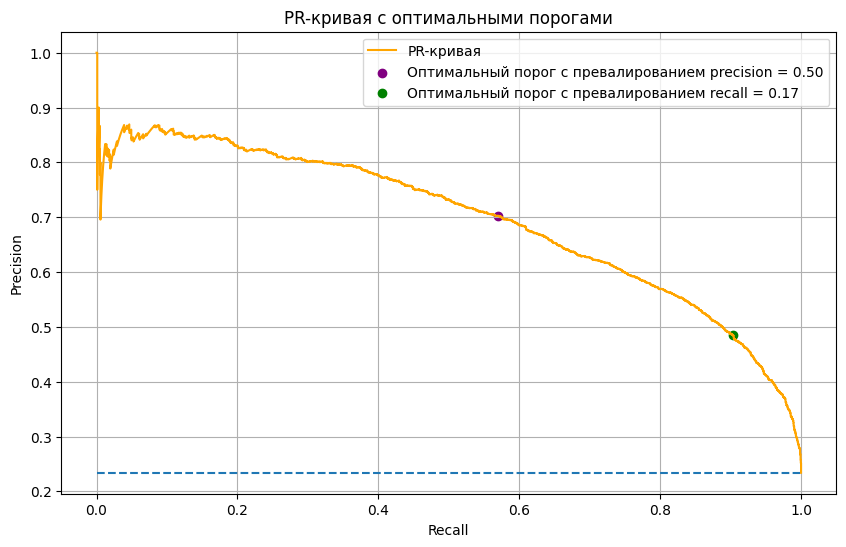

In [65]:
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [no_, no_], linestyle='--')
plt.plot(recall, precision, label='PR-кривая', color='orange')
plt.scatter(
    recall[optimal_idx_precision],
    precision[optimal_idx_precision],
    color='purple',
    label=f'Оптимальный порог с превалированием precision = {optimal_threshold_precision:.2f}'
)
plt.scatter(
    recall[optimal_idx_recall],
    precision[optimal_idx_recall],
    color='green',
    label=f'Оптимальный порог с превалированием recall = {optimal_threshold_recall:.2f}'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая с оптимальными порогами')
plt.legend()
plt.grid()
plt.show()

In [69]:
pr_df = pd.DataFrame({'precision': precision[:12201], 'recall': recall[:12201], 'th': thresholds})
display(pr_df.head(10))
display(pr_df.tail(10))

,precision,recall,th
0,0.233969,1.0,0.000296
1,0.233989,1.0,0.000350
2,0.234008,1.0,0.000450
3,0.234027,1.0,0.000455
4,0.234046,1.0,0.000464
5,0.234065,1.0,0.000473
6,0.234084,1.0,0.000486
7,0.234104,1.0,0.000491
8,0.234123,1.0,0.000501
9,0.234142,1.0,0.000506


,precision,recall,th
12191,0.900000,0.00315,0.946207
12192,0.888889,0.00280,0.946366
12193,0.875000,0.00245,0.947144
12194,0.857143,0.00210,0.949407
12195,0.833333,0.00175,0.949560
12196,0.800000,0.00140,0.949774
12197,0.750000,0.00105,0.953338
12198,1.000000,0.00105,0.954116
12199,1.000000,0.00070,0.957270
12200,1.000000,0.00035,0.960916


#### Вывод:
- При пороге = 0.57, достигается высокое значение precision при относительно низком recall (опттимальный порог при задаче минимизировать ложноположительные ошибки)
- При пороге = 0.15, достигается высокое значение recall при относительно низком precision (опттимальный порог при задаче минимизировать ложноотрицательные ошибки)
- По PR-кривой можно увидеть дисбаланс классов

### Преобразование исходного датасета к сильному дисбалансу (10 к одному соотношение классов в пользу тех кто зарабатывает менее 50k).

In [70]:
df.head(2)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K


Преобразуем датасет с дисбалансом в сторону меньшего заработка с соотношением 10к1

In [71]:
df_less_50 = df[df['income'] == '<=50K']
num_class_more_50 = int(len(df_less_50) / 10)
df_more_50 = df[df['income'] == '>50K'][:num_class_more_50]

df_imbalanced = pd.concat([df_less_50, df_more_50])
df_imbalanced.shape

(40870, 15)

Проведем те же операции препроцессинга и разделения выборки, что и с исходным датасетом

In [73]:
X = df_imbalanced.drop('income', axis=1)
y = df_imbalanced['income']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

x_train, x_test = preprocess_data(df_train=x_train, df_test=x_test)
y_train, y_test = preprocess_data(df_train=y_train, df_test=y_test)

In [74]:
print(y_train.shape[0])
num_class_1 = (y_train == 1).sum()
print(num_class_1)


30652
2791


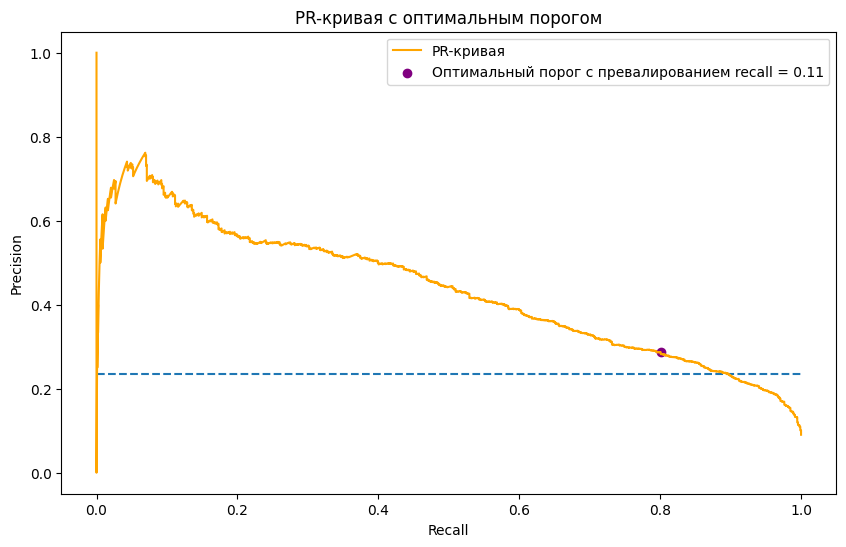

In [75]:
model = LogisticRegression()
model.fit(x_train, y_train)

prob = model.predict_proba(x_test)

precision, recall, thresholds = precision_recall_curve(y_test, prob[:,1])

optimal_idx, optimal_threshold = optimal_param(beta=2,
                                               thresholds=thresholds,
                                               y_pred_proba=prob)

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [no_, no_], linestyle='--')
plt.plot(recall, precision, label='PR-кривая', color='orange')
plt.scatter(
    recall[optimal_idx],
    precision[optimal_idx],
    color='purple',
    label=f'Оптимальный порог с превалированием recall = {optimal_threshold:.2f}'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая с оптимальным порогом')
plt.legend()
plt.show()

Применим SMOTE для балансировки

In [76]:
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(x_train, y_train)
X_smote_test, y_smote_test = smote.fit_resample(x_test, y_test)
print(y_smote_train.shape[0])
num_class_1 = (y_smote_train == 1).sum()
print(num_class_1)

55722
27861


In [77]:
len(X_smote_train)

55722

Заметим увеличение выборки почти в два раза. Это связано с добавлением синтетических данных в датасет

Повторим все шаги

In [78]:
model2 = LogisticRegression()
model2.fit(X_smote_train, y_smote_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [79]:
y_pred_proba = model2.predict_proba(X_smote_test)
y_pred_proba

array([[0.16944462, 0.83055538],
       [0.646717  , 0.353283  ],
       [0.88461657, 0.11538343],
       ...,
       [0.03260042, 0.96739958],
       [0.13477499, 0.86522501],
       [0.02545853, 0.97454147]], shape=(18588, 2))

In [80]:
precision, recall, thresholds2 = precision_recall_curve(y_smote_test, y_pred_proba[:,1])

Для миноритарного класса важно усиление вляния recall. А значит надо взять beta больше одного

In [81]:
optimal_idx, optimal_threshold = optimal_param(beta=2,
                                               thresholds=thresholds2,
                                               y_pred_proba=y_pred_proba[:10218])

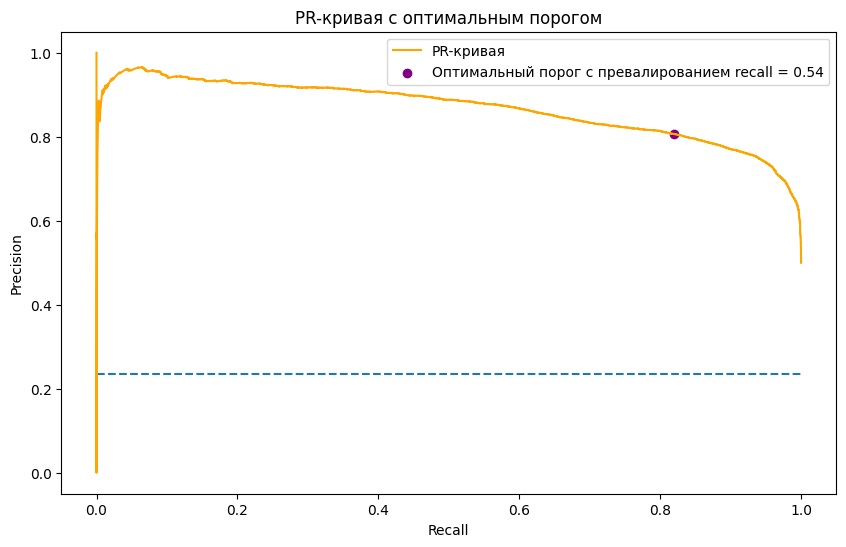

In [82]:
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [no_, no_], linestyle='--')
plt.plot(recall, precision, label='PR-кривая', color='orange')
plt.scatter(
    recall[optimal_idx],
    precision[optimal_idx],
    color='purple',
    label=f'Оптимальный порог с превалированием recall = {optimal_threshold:.2f}'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая с оптимальным порогом')
plt.legend()
plt.show()

Чем выше и правее расположена PR-кривая, тем лучше модель.
#### Вывод:
- Кривая изменила свое положение - начинается высоко и постепенно снижается, что говорит о улучшении качестве модели, но не идеальности.